In [1]:
%matplotlib inline 

In [2]:
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import matplotlib.pyplot as plt

## ACT Parameters
We write down the ACT parameters (these are from the multifrequency likelihood).

In [3]:
par = {
    'nu_0' : 150.0,
    'ell_0' : 3000,
    'T_CMB' : 2.725,
    'T_d' : 9.7,

    'a_tSZ' : 4.66,
    'a_kSZ' : 1.60,
    'a_p' : 6.87,
    'beta_p' : 2.08,
    'a_c' : 6.10,
    'beta_c' : 2.08,
    'n_CIBC' : 1.20,
    'xi' : 0.09,
    'a_s' :3.50,
    'a_g' :0.88,

    'f0_sz' : 146.9,
    'f0_synch'  :147.6,
    'f0_dust'   :149.7
}

Note the inclusion of effective frequencies (i.e. Page et al. 2003). You hopefully won't be using these, but in the last part of this notebook we'll have to use them in order to check against the ACT multifrequency likelihood.

## Models

In [4]:
ksz = fgc.FactorizedCrossSpectrum(fgf.UnitSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw_g(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw_g(), fgp.PowerLaw())

# if there are correlations between components, 
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), 
    fgp.SZxCIB_Addison2012())

# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())

## Calling the Models

We can call the models individually by looking at their signatures.

In [5]:
print(tsz)

SED arguments: (nu, nu_0, T_CMB=2.725)
Cl arguments: (ell, ell_0, amp=1.0)


In [6]:
freqs = np.array([150.0])
ells = np.arange(2, 3000)
spec = par['a_tSZ'] * tsz(
    [freqs, par['nu_0'], par['T_CMB']], 
    [ells, par['ell_0']]
)

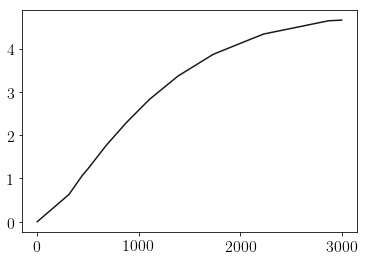

In [7]:
plt.plot(spec[0,0,:])

## All The Models

To make a combined model, usually you should wrap `fgspectra` in your own function call and pass in whatever dictionary elements you want, so you can name your parameters.

In [8]:
 par['a_s'] * radio(
                [freqs, -0.5, par['nu_0'], par['T_CMB']],
                [ells, 2, par['ell_0']])

array([[[1.55555556e-06, 3.50000000e-06, 6.22222222e-06, ...,
         3.49300350e+00, 3.49533489e+00, 3.49766706e+00]]])

In [9]:
print(cibp)

SED arguments: (nu, beta, T_d, nu_0, T_CMB=2.725)
Cl arguments: (ell, alpha, ell_0, amp=1.0)


In [10]:
def get_fg_model(freqs, ells, par):
    return (
            tSZ_and_CIB(
                sed_args=((freqs, par['nu_0'], par['T_CMB']),
                  (freqs, par['beta_c'], par['T_d'], par['nu_0'])),
                cl_args=[(ells, par['ell_0'], par['a_tSZ']),
                        (ells, 2-par['n_CIBC'], par['ell_0'], par['a_c']),
                        (ells, par['ell_0'], -2*par['xi'] * np.sqrt(par['a_tSZ'] * par['a_c']))])   , 
            par['a_kSZ'] * ksz(
                [freqs], 
                [ells, par['ell_0']]) ,
            par['a_p'] * cibp(
                [freqs, par['beta_p'], par['T_d'],par['nu_0']],
                [ells, 2, par['ell_0']]) ,
            par['a_s'] * radio(
                [freqs, -0.5, par['nu_0'], par['T_CMB']],
                [ells, 2, par['ell_0']]) ,
            par['a_g'] * cirrus(
                [freqs, 3.8, par['nu_0'], par['T_CMB']],
                [ells, -0.7, par['ell_0']])
    )

In [11]:
specs = get_fg_model(freqs, ells, par)

In [12]:
specs

(array([[[0.01752468, 0.026217  , 0.03445285, ..., 8.83751317,
          8.83854691, 8.83958888]]]),
 array([[[1.05951143e-05, 6.64041374e-04, 1.31749187e-03, ...,
          1.59961858e+00, 1.59974572e+00, 1.59987286e+00]]]),
 array([[[3.05333333e-06, 6.87000000e-06, 1.22133333e-05, ...,
          6.85626687e+00, 6.86084305e+00, 6.86542076e+00]]]),
 array([[[1.55555556e-06, 3.50000000e-06, 6.22222222e-06, ...,
          3.49300350e+00, 3.49533489e+00, 3.49766706e+00]]]),
 array([[[147.14535378, 110.78543624,  90.57859013, ...,   0.88061652,
            0.8804109 ,   0.88020539]]]))

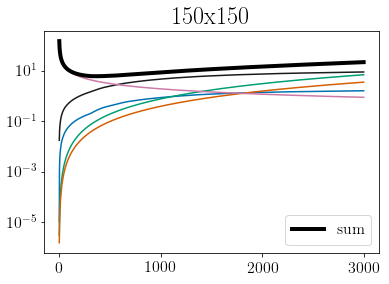

In [22]:
for spec in specs:
    plt.plot(ells, spec[0,0])
    
plt.plot( ells, np.sum( [s[0,0] for s in specs] , axis=0), 'k-', lw=4, label='sum' )
plt.legend()
plt.title('150x150')
plt.yscale('log')